<a href="https://colab.research.google.com/github/hkevincho/Pison/blob/main/Pison_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PISON Technical Challenge

## Setup

In [1]:
# Import Packges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [11]:
# os.getcwd()

'/content'

In [ ]:
# !pip install sktime

In [ ]:
# !pip install tslearn

In [2]:
# from tslearn.clustering import TimeSeriesKMeans

## Import Data

In [3]:
col_names = ['timestamp',
             'channel_0_raw',
             'channel_1_raw',
             'channel_0_high_passed',
             'channel_1_high_passed',
             'quaternion_x',
             'quaternion_y',
             'quaternion_z',
             'quaternion_w',
             'gyroscope_x',
             'gyroscope_y',
             'gyroscope_z',
             'accelerometer_x',
             'accelerometer_y',
             'accelerometer_z',
             'body_movement',
             'repetition_num']
df_raw = pd.read_csv('/content/drive/MyDrive/Technical_challenge/pison_data_interview_2.csv', names=col_names)
print('data shape:', df_raw.shape)
df_raw.head(5)

data shape: (14981, 17)


,timestamp,channel_0_raw,channel_1_raw,channel_0_high_passed,channel_1_high_passed,quaternion_x,quaternion_y,quaternion_z,quaternion_w,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,body_movement,repetition_num
0,1514824.503,12535249,12566283,-11889,17295,0.32196,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.21875,0,1
1,1514827.496,12536264,12559246,-2063,13384,0.32196,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.21875,0,1
2,1514830.493,12538584,12565279,2757,16008,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
3,1514833.500,12546745,12567024,7504,5644,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
4,1514836.498,12537375,12545467,-3855,-15893,0.32196,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.21875,0,1


## EDA

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa59c6e9490>,
      dtype=object)

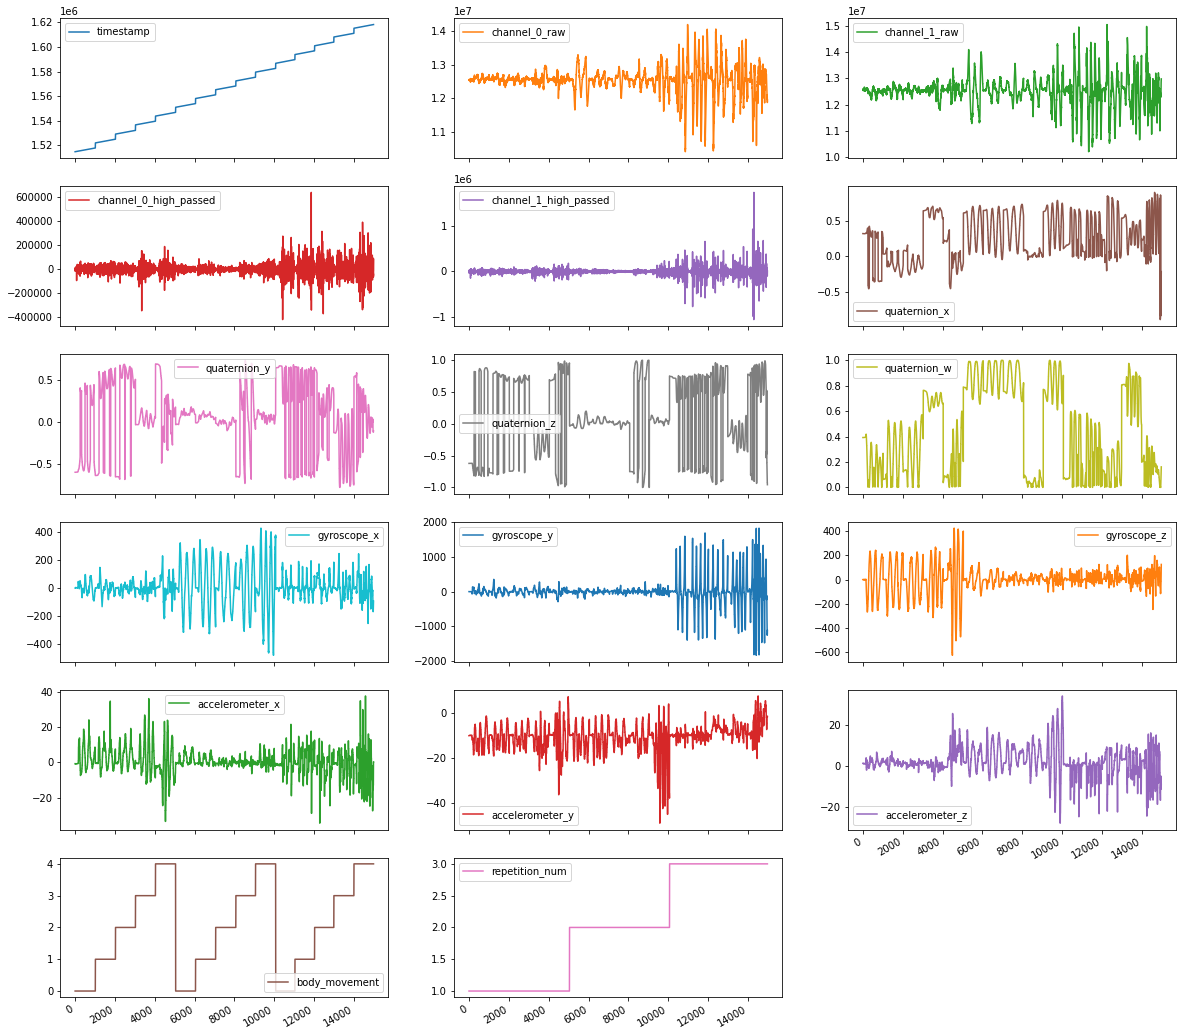

In [4]:
df_raw.plot(subplots=True, layout=(6, 3), figsize=(20, 20))

- The body movement seems to follow repeating pattern. Standing #1, standing #2, walking, walking fast, and running -> Repeat...
- Repetition num lines up with body movement segmentation. First around 5000, and 10,000, then about 15,000

## Data Processing

In [89]:
# Drop non-relevant columns
col_keep = [ 'quaternion_x',
             'quaternion_y',
             'quaternion_z',
             'quaternion_w',
             'gyroscope_x',
             'gyroscope_y',
             'gyroscope_z',
             'accelerometer_x',
             'accelerometer_y',
             'accelerometer_z',
             'body_movement',
             'repetition_num']
df_processed = df_raw[col_keep]

In [134]:
# Create unique rep and body list
unique_rep = df_processed['repetition_num'].unique()
unique_body = df_processed['body_movement'].unique()

# Define window to calculate time series characteristics
window = 10

# Label each time series segment
appended_df = []
for i in unique_rep:
  for j in unique_body:
    df_temp = df_processed[(df_processed['repetition_num']==i) & (df_processed['body_movement']==j)]
    df_temp.drop(['repetition_num', 'body_movement'], axis=1, inplace=True)

    # Data operation
    df_temp_mean = df_temp.rolling(window).mean()
    df_temp_mean.rename(columns=lambda s: s+'_mean', inplace=True)

    df_temp_range = df_temp.rolling(window).max() - df_temp.rolling(window).min()
    df_temp_range.rename(columns=lambda s: s+'_range', inplace=True)

    df_temp_var = df_temp.rolling(window).var()
    df_temp_var.rename(columns=lambda s: s+'_var', inplace=True)

    # Merge dataframe
    df_merge = pd.concat([df_temp_mean, df_temp_range, df_temp_var], axis=1)

    # Drop nan in window segment
    df_merge = df_merge.iloc[window-1:, :]

    # Append dataframe
    appended_df.append(df_merge)

# Concatenate final df
final_df = pd.concat(appended_df)

final_df.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

,quaternion_x_mean,quaternion_y_mean,quaternion_z_mean,quaternion_w_mean,gyroscope_x_mean,gyroscope_y_mean,gyroscope_z_mean,accelerometer_x_mean,accelerometer_y_mean,accelerometer_z_mean,quaternion_x_range,quaternion_y_range,quaternion_z_range,quaternion_w_range,gyroscope_x_range,gyroscope_y_range,gyroscope_z_range,accelerometer_x_range,accelerometer_y_range,accelerometer_z_range,quaternion_x_var,quaternion_y_var,quaternion_z_var,quaternion_w_var,gyroscope_x_var,gyroscope_y_var,gyroscope_z_var,accelerometer_x_var,accelerometer_y_var,accelerometer_z_var
9,0.322003,-0.596765,-0.621796,0.391919,-0.967985,0.677030,-0.609887,-0.698438,-9.989062,1.234375,0.000122,0.000183,0.000061,0.000305,1.286917,1.119058,1.790493,0.191406,0.074219,0.078125,3.352724e-09,3.477490e-09,1.035645e-09,8.940353e-09,0.158658,0.242423,0.348867,0.006513,0.000979,0.001085
10,0.322015,-0.596783,-0.621796,0.391888,-0.856080,0.593101,-0.744174,-0.717578,-9.981640,1.242188,0.000122,0.000061,0.000061,0.000244,1.286917,1.119058,1.286917,0.191406,0.074219,0.078125,3.683873e-09,8.699422e-10,1.035645e-09,6.663750e-09,0.190661,0.240857,0.196923,0.008548,0.001285,0.001424
11,0.322028,-0.596790,-0.621796,0.391864,-0.682626,0.470004,-0.844889,-0.736719,-9.974219,1.250000,0.000122,0.000061,0.000061,0.000183,1.454776,1.230964,1.007152,0.191406,0.074219,0.078125,3.683886e-09,6.628131e-10,1.035645e-09,5.008251e-09,0.239188,0.233204,0.131804,0.009770,0.001469,0.001628
12,0.322046,-0.596790,-0.621802,0.391846,-0.481195,0.229407,-0.906437,-0.755859,-9.966797,1.257812,0.000183,0.000061,0.000061,0.000183,2.014305,2.405975,1.007152,0.191406,0.074219,0.078125,4.304676e-09,6.628131e-10,9.942196e-10,4.139055e-09,0.399481,0.435136,0.092391,0.010177,0.001530,0.001695
13,0.322064,-0.596790,-0.621808,0.391827,-0.279765,-0.011191,-0.967985,-0.775000,-9.959375,1.265625,0.000183,0.000061,0.000061,0.000122,1.846446,2.070258,0.559529,0.191406,0.074219,0.078125,4.180453e-09,6.628131e-10,8.699422e-10,2.524845e-09,0.469609,0.508430,0.044561,0.009770,0.001469,0.001628
14,0.322083,-0.596777,-0.621820,0.391815,-0.072739,-0.145478,-0.984771,-0.794141,-9.951953,1.273438,0.000183,0.000122,0.000122,0.000122,2.070257,2.070258,0.559529,0.191406,0.074219,0.078125,3.311217e-09,1.821434e-09,1.200454e-09,1.862534e-09,0.537824,0.434963,0.038404,0.008548,0.001285,0.001424
15,0.322101,-0.596765,-0.621832,0.391803,0.134287,-0.279765,-1.001557,-0.813281,-9.944531,1.281250,0.000122,0.000122,0.000122,0.000061,1.790493,1.454776,0.447623,0.191406,0.074219,0.078125,1.696966e-09,2.648973e-09,1.199884e-09,8.690875e-10,0.510796,0.321421,0.031620,0.006513,0.000979,0.001085
16,0.322119,-0.596747,-0.621845,0.391797,0.330122,-0.341313,-0.900842,-0.832422,-9.937109,1.289062,0.000122,0.000183,0.000061,0.000061,1.790493,1.454776,0.951200,0.191406,0.074219,0.078125,1.821325e-09,4.511629e-09,8.682333e-10,6.621619e-10,0.494968,0.298080,0.069189,0.003664,0.000551,0.000610
17,0.322125,-0.596722,-0.621857,0.391797,0.553934,-0.391670,-0.727388,-0.851562,-9.929688,1.296875,0.000122,0.000244,0.000122,0.000061,2.238116,1.454776,1.734540,0.000000,0.000000,0.000000,1.697143e-09,7.492389e-09,1.861313e-09,6.621619e-10,0.525580,0.278983,0.242805,0.000000,0.000000,0.000000
18,0.322131,-0.596698,-0.621869,0.391797,0.777745,-0.442028,-0.553934,-0.851562,-9.929688,1.296875,0.000122,0.000244,0.000122,0.000061,1.846446,1.454776,1.510728,0.000000,0.000000,0.000000,1.490190e-09,9.148391e-09,2.523421e-09,6.621619e-10,0.444876,0.254250,0.349563,0.000000,0.000000,0.000000


In [135]:
# Check df shape
final_df.shape # this is correct as 14981 - 14846 = 135. 9*15 = 135 which is what is missing when doing rolling window of 10

(14846, 30)

In [136]:
# Check that there is no NaN
final_df[final_df.isna().any(axis=1)]

,quaternion_x_mean,quaternion_y_mean,quaternion_z_mean,quaternion_w_mean,gyroscope_x_mean,gyroscope_y_mean,gyroscope_z_mean,accelerometer_x_mean,accelerometer_y_mean,accelerometer_z_mean,quaternion_x_range,quaternion_y_range,quaternion_z_range,quaternion_w_range,gyroscope_x_range,gyroscope_y_range,gyroscope_z_range,accelerometer_x_range,accelerometer_y_range,accelerometer_z_range,quaternion_x_var,quaternion_y_var,quaternion_z_var,quaternion_w_var,gyroscope_x_var,gyroscope_y_var,gyroscope_z_var,accelerometer_x_var,accelerometer_y_var,accelerometer_z_var


## Model

In [137]:
from sklearn.cluster import KMeans

Text(0, 0.5, 'WCSS')

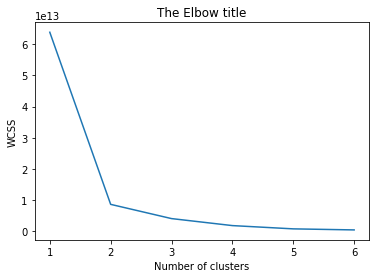

In [139]:
wcss=[]
for i in range(1,7):
  kmeans = KMeans(i)
  kmeans.fit(final_df)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [146]:
# Perform PCA to two dimensions to visualize
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(final_df)

Text(0, 0.5, 'WCSS')

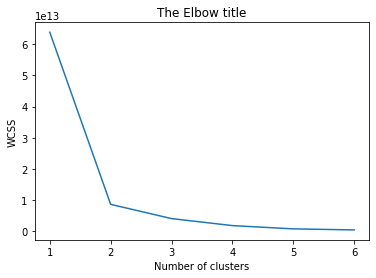

In [147]:
# Perform KMeans
wcss=[]
for i in range(1,7):
  kmeans = KMeans(i)
  kmeans.fit(reduced_data)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

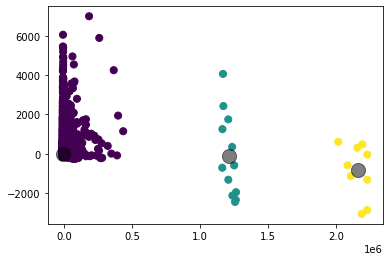

In [158]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(reduced_data)
y_kmeans = kmeans.predict(reduced_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## Trying Stuff

In [48]:
# model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=10)
# model.fit(df_raw)

In [49]:
# model.cluster_centers_

In [38]:
df_raw[(df_raw['repetition_num']==1) & (df_raw['body_movement']==0)]

,timestamp,channel_0_raw,channel_1_raw,channel_0_high_passed,channel_1_high_passed,quaternion_x,quaternion_y,quaternion_z,quaternion_w,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,body_movement,repetition_num
0,1514824.503,12535249,12566283,-11889,17295,0.321960,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.218750,0,1
1,1514827.496,12536264,12559246,-2063,13384,0.321960,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.218750,0,1
2,1514830.493,12538584,12565279,2757,16008,0.321960,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.218750,0,1
3,1514833.500,12546745,12567024,7504,5644,0.321960,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.218750,0,1
4,1514836.498,12537375,12545467,-3855,-15893,0.321960,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.218750,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,1517850.217,12673747,12351166,-963,-3734,0.256470,-0.610168,-0.703491,0.258911,-20.254953,22.940693,180.224320,5.277344,-13.796875,3.710938,0,1
1010,1517853.155,12666856,12368175,-2388,6356,0.256470,-0.610168,-0.703491,0.258911,-20.254953,22.940693,180.224320,5.277344,-13.796875,3.710938,0,1
1011,1517856.157,12672234,12356511,6304,-10761,0.251404,-0.612915,-0.701233,0.263611,-18.576366,18.968037,176.363570,5.277344,-13.796875,3.710938,0,1
1012,1517859.160,12683170,12381392,10831,18598,0.246399,-0.615479,-0.698975,0.268188,-16.618013,18.464460,171.663530,5.277344,-13.796875,3.710938,0,1


SKTIME Example

In [5]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline

from sktime.datasets import load_arrow_head  # univariate dataset
from sktime.datasets import load_basic_motions  # multivariate dataset
from sktime.transformations.panel.rocket import Rocket

In [8]:
X_train, y_train = load_arrow_head(split="train", return_X_y=True)

In [21]:
X_train.iloc[0]

dim_0    0     -1.9630
1     -1.9578
2     -1.9561
3   ...
Name: 0, dtype: object

In [20]:
X_train.head()

,dim_0
0,0 -1.9630 1 -1.9578 2 -1.9561 3 ...
1,0 -1.7746 1 -1.7740 2 -1.7766 3 ...
2,0 -1.8660 1 -1.8420 2 -1.8350 3 ...
3,0 -2.0738 1 -2.0733 2 -2.0446 3 ...
4,0 -1.7463 1 -1.7413 2 -1.7227 3 ...


In [27]:
X_train['dim_0'][0]

0     -1.9630
1     -1.9578
2     -1.9561
3     -1.9383
4     -1.8967
        ...  
246   -1.8413
247   -1.8843
248   -1.9054
249   -1.9239
250   -1.9092
Length: 251, dtype: float64

Tslearn Example

In [15]:
from tslearn.generators import random_walks
X = random_walks(n_ts=50, sz=32, d=1)

In [21]:
X.shape

(50, 32, 1)

In [17]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0).fit(X)
km.cluster_centers_.shape
km_dba = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, max_iter_barycenter=5, random_state=0).fit(X)
km_dba.cluster_centers_.shape

(3, 32, 1)

In [ ]:
km_dba.cluster_centers_